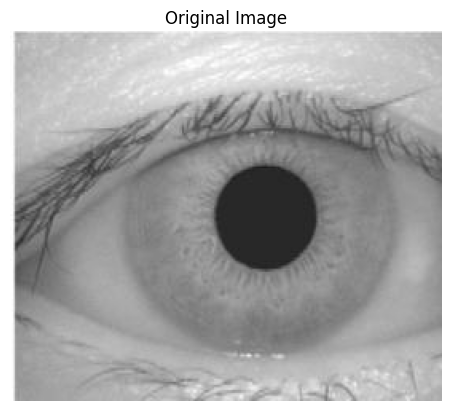

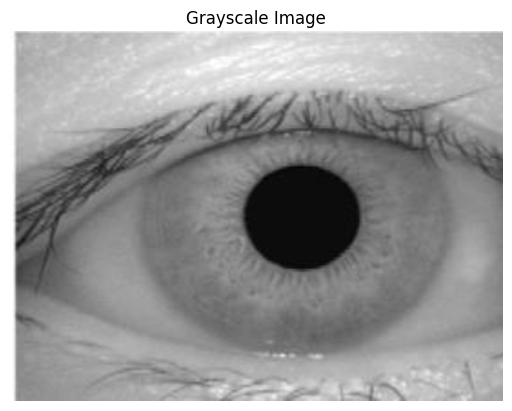

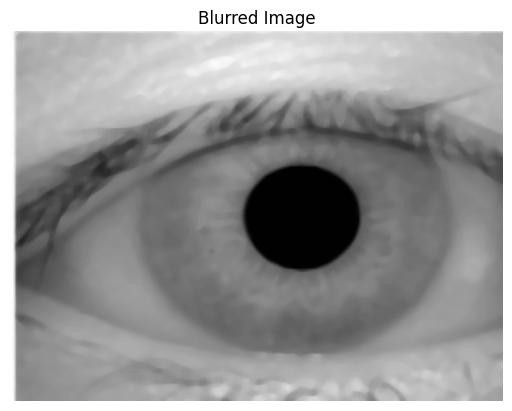

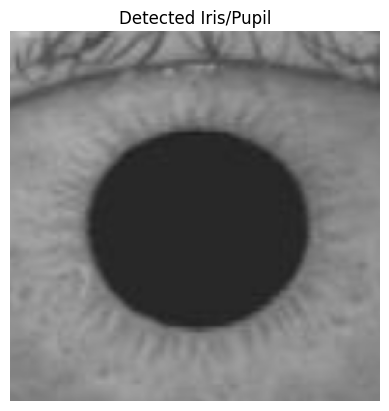

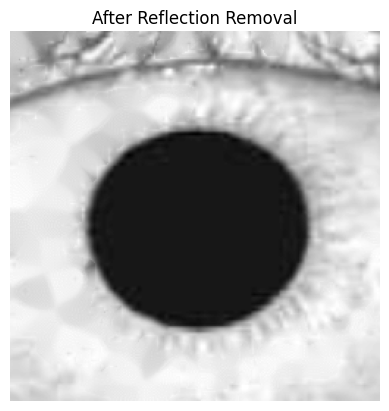

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import plotly.graph_objs as go

# Function to save and display an image using matplotlib
def display_image(image, title='Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to generate the rubber sheet model (polar unwrapping)
def generate_rubber_sheet_model(img):
    q = np.arange(0.00, np.pi/3, 0.001)
    inn = np.arange(0, int(img.shape[0] / 2), 1)
    cartisian_image = np.empty(shape=[inn.size, int(img.shape[1]), 3])

    m = interp1d([np.pi * 2, 0], [0, img.shape[1]])

    for r in inn:
        for t in q:
            polarX = int((r * np.cos(t)) + img.shape[1] / 2)
            polarY = int((r * np.sin(t)) + img.shape[0] / 2)
            try:
                cartisian_image[r][int(m(t) - 1)] = img[polarY][polarX]
            except:
                pass

    return cartisian_image.astype("uint8")

# Function to remove reflection using inpainting
def remove_reflection(img):
    # Ensure the image is grayscale (single channel)
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Generate binary mask using threshold
    ret, mask = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

    # The mask should be single-channel (already binary), ensure it's 8-bit
    if len(mask.shape) > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=2)

    # Inpainting using the corrected mask
    dst = cv2.inpaint(img, dilation, 5, cv2.INPAINT_TELEA)
    return dst

# Function to process the image and detect circles
def processing(image_path, r):
    success = False
    original_image = cv2.imread(image_path)
    display_image(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), "Original Image")

    image = cv2.resize(original_image, (640, 480), interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    display_image(gray, "Grayscale Image")

    gray_blurred = cv2.medianBlur(gray, 11)
    display_image(gray_blurred, "Blurred Image")

    ret, _ = cv2.threshold(gray_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Detect circles (iris/pupil) using Hough Circles
    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        1,
        50,
        param1=ret,
        param2=30,
        minRadius=20,
        maxRadius=100,
    )

    if circles is not None:
        circles = circles[0, :, :]
        circles = np.int16(np.array(circles))
        for i in circles[:]:
            image_roi = image[
                i[1] - i[2] - r : i[1] + i[2] + r, i[0] - i[2] - r : i[0] + i[2] + r
            ]
            radius = i[2]
            display_image(image_roi, "Detected Iris/Pupil")
        success = True
        return image_roi, radius, success
    else:
        print(f"{image_path} -> No circles (iris) found.")
        return None, None, success

# Function to display the rubber sheet model using Plotly
def display_rubber_sheet_plotly(rubber_sheet):
    # Create a Plotly heatmap
    fig = go.Figure(data=go.Heatmap(z=rubber_sheet[..., 0], colorscale='gray'))

    # Set titles and labels
    fig.update_layout(
        title="Rubber Sheet Model",
        xaxis_title="Theta",
        yaxis_title="Radius",
        height=800,
        width=800
    )

    # Show the Plotly figure with zoom and interaction enabled
    fig.show()

# Main processing function
def process_img(image_path, keep_reflection=False):
    image_roi, rr, success = processing(image_path, 50)

    if success:
        if not keep_reflection:
            image_roi = remove_reflection(image_roi)
            display_image(image_roi, "After Reflection Removal")

        # Generate and display the rubber sheet model
        rubber_sheet = generate_rubber_sheet_model(image_roi)
        display_rubber_sheet_plotly(rubber_sheet)
    else:
        print("Iris or Pupil not detected.")

# Test the function on your image
image_path = 'eye.jpg'  # Replace with your image file
process_img(image_path)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis, variation
from statistics import mode
import plotly.graph_objs as go

# Function to generate the rubber sheet model (polar unwrapping)
def generate_rubber_sheet_model(img):
    q = np.arange(0.00, np.pi / 3, 0.001)
    inn = np.arange(0, int(img.shape[0] / 2), 1)
    cartisian_image = np.empty(shape=[inn.size, int(img.shape[1]), 3])

    m = interp1d([np.pi * 2, 0], [0, img.shape[1]])

    for r in inn:
        for t in q:
            polarX = int((r * np.cos(t)) + img.shape[1] / 2)
            polarY = int((r * np.sin(t)) + img.shape[0] / 2)
            if 0 <= polarX < img.shape[1] and 0 <= polarY < img.shape[0]:  # Check bounds
                cartisian_image[r][int(m(t) - 1)] = img[polarY][polarX]
    return cartisian_image.astype("uint8")

# Function to remove reflection using inpainting
def remove_reflection(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    if len(mask.shape) > 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(mask, kernel, iterations=2)
    dst = cv2.inpaint(img, dilation, 5, cv2.INPAINT_TELEA)
    return dst

# Function to process the image and detect circles
def processing(image_path, r):
    success = False
    original_image = cv2.imread(image_path)
    image = cv2.resize(original_image, (640, 480), interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_blurred = cv2.medianBlur(gray, 11)
    ret, _ = cv2.threshold(gray_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    circles = cv2.HoughCircles(
        gray_blurred,
        cv2.HOUGH_GRADIENT,
        1,
        50,
        param1=ret,
        param2=30,
        minRadius=20,
        maxRadius=100,
    )

    if circles is not None:
        circles = circles[0, :, :]
        circles = np.int16(np.array(circles))
        for i in circles[:]:
            image_roi = image[
                i[1] - i[2] - r : i[1] + i[2] + r, i[0] - i[2] - r : i[0] + i[2] + r
            ]
            radius = i[2]
        success = True
        return image_roi, radius, success
    else:
        print(f"{image_path} -> No circles (iris) found.")
        return None, None, success

# Updated function to handle precision loss in statistics
def compute_rubber_sheet_statistics(rubber_sheet):
    means, medians, modes, skewnesses, kurtoses = [], [], [], [], []
    for row in rubber_sheet[..., 0]:  # Assuming grayscale or red channel
        row_data = row[row > 0]  # Exclude any zero-padded areas
        if len(row_data) > 0:
            means.append(np.mean(row_data))
            medians.append(np.median(row_data))
            try:
                modes.append(mode(row_data))
            except:
                modes.append(np.nan)  # Handle multiple modes by storing NaN

            # Check for minimal variance
            if np.var(row_data) > 1e-5:  # Small threshold for variance
                skewnesses.append(skew(row_data))
                kurtoses.append(kurtosis(row_data))
            else:
                skewnesses.append(np.nan)
                kurtoses.append(np.nan)
        else:
            means.append(np.nan)
            medians.append(np.nan)
            modes.append(np.nan)
            skewnesses.append(np.nan)
            kurtoses.append(np.nan)
    return means, medians, modes, skewnesses, kurtoses


# Main processing function
def process_img(image_path, keep_reflection=False):
    image_roi, rr, success = processing(image_path, 50)

    if success:
        if not keep_reflection:
            image_roi = remove_reflection(image_roi)

        # Generate the rubber sheet model
        rubber_sheet = generate_rubber_sheet_model(image_roi)

        # Compute statistics for each row
        means, medians, modes, skewnesses, kurtoses = compute_rubber_sheet_statistics(rubber_sheet)

        # Display the computed statistics
        print("Row-wise Statistics for Rubber Sheet Model:")
        print("Means:", means)
        print("Medians:", medians)
        print("Modes:", modes)
        print("Skewness:", skewnesses)
        print("Kurtosis:", kurtoses)
    else:
        print("Iris or Pupil not detected.")

# Test the function on your image
image_path = 'eye.jpg'  # Replace with your image file
process_img(image_path)


Row-wise Statistics for Rubber Sheet Model:
Means: [40.0, 58.8, 50.40816326530612, 51.98, 53.21568627450981, 57.648148148148145, 54.78846153846154, 52.18, 48.979166666666664, 47.57446808510638, 56.41509433962264, 51.98, 41.93181818181818, 41.88636363636363, 41.93181818181818, 41.97727272727273, 48.9375, 54.94230769230769, 54.67307692307692, 57.31481481481482, 56.22641509433962, 50.69387755102041, 51.98, 62.12068965517241, 69.35384615384615, 63.42372881355932, 51.94, 59.09090909090909, 53.92156862745098, 56.0, 48.979166666666664, 55.924528301886795, 50.44897959183673, 45.5, 48.895833333333336, 54.90384615384615, 53.372549019607845, 54.86538461538461, 55.886792452830186, 57.425925925925924, 54.82692307692308, 45.54347826086956, 49.020833333333336, 50.61224489795919, 49.0625, 41.88636363636363, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 42.04545454545455, 40.0, 40.02325581395349, 39.93181818181818, 40.2093023255814, 39.97674418604651, 39.69767441860465, 39.51162790697674, 39.53

<ipython-input-5-38b9b669a2f3>:23: RuntimeWarning:

invalid value encountered in cast



<ipython-input-5-38b9b669a2f3>:23: RuntimeWarning:

invalid value encountered in cast



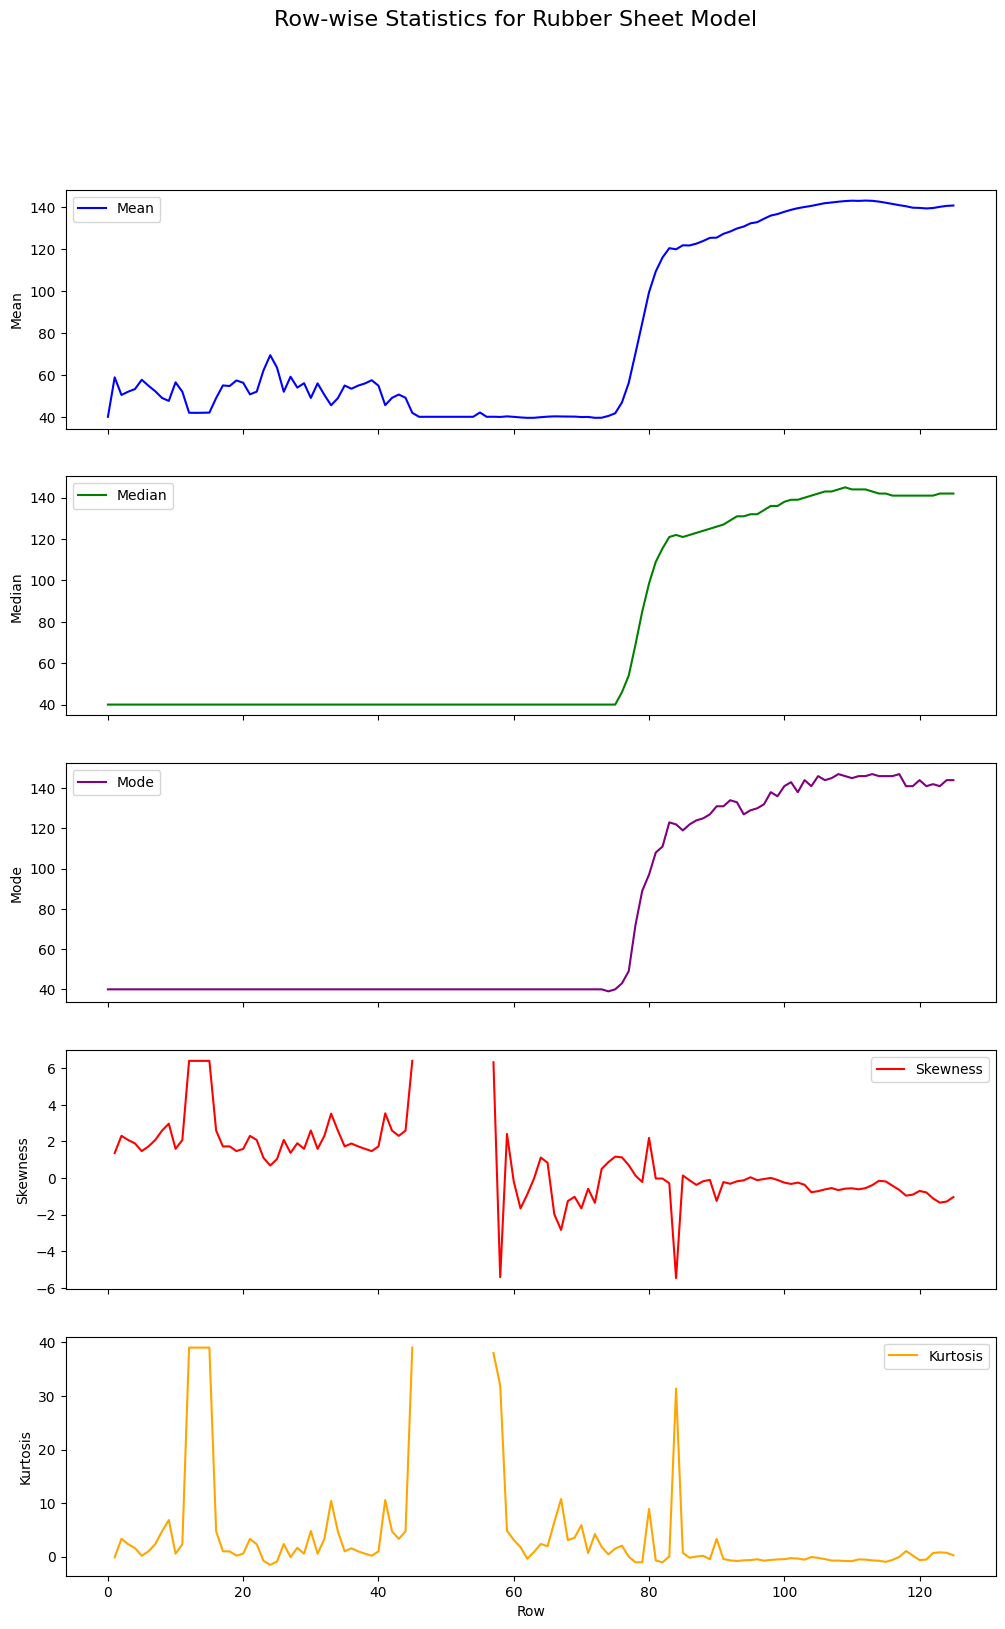

In [ ]:
import matplotlib.pyplot as plt

# Function to plot the row-wise statistics
def plot_rubber_sheet_statistics(means, medians, modes, skewnesses, kurtoses):
    """

    Args:
      means:
      medians:
      modes:
      skewnesses:
      kurtoses:
    """
    rows = range(len(means))

    # Set up the plotting area with subplots for each statistic
    fig, axs = plt.subplots(5, 1, figsize=(12, 18), sharex=True)
    fig.suptitle("Row-wise Statistics for Rubber Sheet Model", fontsize=16)

    # Plot means
    axs[0].plot(rows, means, color='blue', label='Mean')
    axs[0].set_ylabel("Mean")
    axs[0].legend()
    # Finished plotting means
    # Plot medians
    axs[1].plot(rows, medians, color='green', label='Median')
    axs[1].set_ylabel("Median")
    axs[1].legend()
    # Plot medians completed
    # Plot modes
    axs[2].plot(rows, modes, color='purple', label='Mode')
    axs[2].set_ylabel("Mode")
    axs[2].legend()
    # Plot modes completed.
    # Plot skewness
    axs[3].plot(rows, skewnesses, color='red', label='Skewness')
    axs[3].set_ylabel("Skewness")
    axs[3].legend()
    # Plotted skewness and it has been completed.
    # Plot kurtosis
    axs[4].plot(rows, kurtoses, color='orange', label='Kurtosis')
    axs[4].set_ylabel("Kurtosis")
    axs[4].set_xlabel("Row")
    axs[4].legend()
    # testing starts now.
    # Display the plots
    plt.show()

# Integrate plotting into the main function after statistics are computed
def process_img(image_path, keep_reflection=False):
    image_roi, rr, success = processing(image_path, 50)

    if success:
        if not keep_reflection:
            image_roi = remove_reflection(image_roi)

        # Generate the rubber sheet model
        rubber_sheet = generate_rubber_sheet_model(image_roi)

        # Compute statistics for each row
        means, medians, modes, skewnesses, kurtoses = compute_rubber_sheet_statistics(rubber_sheet)

        # Plot the computed statistics
        plot_rubber_sheet_statistics(means, medians, modes, skewnesses, kurtoses)
    else:
        print("Iris or Pupil not detected.")

# Test the function on your image
image_path = 'eye.jpg'  # Replace with your image file
process_img(image_path)

In [ ]:
"""
A neuron in the wild.
"""
inputs = [1,2,3] # outputs of neurons from previous layer
weights = [0.2,0.8,-0.5] # add weights
# A unique neuron has unique bias.
bias = 2
"""
Why only one bias?
Imagine full neural network, single neuron is selected,
it has three inputs to it, so one bias is associated to it.
"""
outputs = 0
for i in range(len(inputs)):
    outputs += inputs[i]*weights[i]
print(outputs+bias)

2.3


In [ ]:
"""
Modelling a layer in CNN with 3 neurons and 4 inputs, so outputs need to be 3.

I[0..4]                   N1    --> O1
I[0..4]                   N2    --> O2
I[0..4]                   N3    --> O3

"""
inputs = [1,2,3,2.5] # outputs of neurons from previous layer
weights1 = [0.2,0.8,-0.5,1.0] # add weights
weights2 = [0.5,-0.91,0.26,-0.5] # add weights
weights3 = [-0.26,-0.27,0.17,0.87] # add weights

# A unique neuron has unique bias.
bias1 = 1
bias2 = 2
bias3 = 3

output1 = inputs[0]*weights1[0] + inputs[1]*weights1[1] + inputs[2]*weights1[2] + bias1
output2 = inputs[0]*weights2[0] + inputs[1]*weights2[1] + inputs[2]*weights2[2] + bias2
output3 = inputs[0]*weights3[0] + inputs[1]*weights3[1] + inputs[2]*weights3[2] + bias3
print(output1 , output2 , output3)

1.3 1.46 2.71


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
